In [2]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [29]:
#список стоп-слов
stopword_list = set(stopwords.words('russian'))
# no_stopwords = ['не', 'нет', 'без', 'никогда']

# for no_stopword in no_stopwords:
#     stopword_list.remove(no_stopword)

print(f'Финальнй список стоп слов:\n{stopword_list}')

#lemma
lemmatizer = pymorphy3.MorphAnalyzer()

def lemma_stem_text(word_list):
    lemma = []
    for word in word_list:
        p = lemmatizer.parse(word)[0]
        lemma.append(p.normal_form)
    return lemma

#summary
def review_to_words(raw_review):
    #оставляем только буквы и цифры
    letters_numbers_only = re.sub('[^А-Яа-яёЁ0-9]', ' ', raw_review)
    #приводим все к нижнему регистру
    words = np.char.lower(letters_numbers_only.split())
    #убираем стоп-слова
    without_stop_words = [w for w in words if not w in stopword_list]
    #лемматизация
    lemma_words = lemma_stem_text(without_stop_words)
    return ' '.join(lemma_words)


Финальнй список стоп слов:
{'про', 'мы', 'чтоб', 'какой', 'всех', 'до', 'есть', 'нельзя', 'мой', 'ли', 'себя', 'тем', 'перед', 'а', 'между', 'свою', 'уже', 'какая', 'ни', 'чего', 'после', 'так', 'ну', 'где', 'ведь', 'ему', 'там', 'ее', 'наконец', 'вас', 'при', 'никогда', 'на', 'не', 'нас', 'что', 'под', 'еще', 'мне', 'вдруг', 'уж', 'того', 'один', 'все', 'была', 'этот', 'через', 'будет', 'тут', 'эту', 'даже', 'сам', 'моя', 'к', 'он', 'она', 'опять', 'из', 'был', 'эти', 'сейчас', 'всего', 'ним', 'в', 'его', 'и', 'бы', 'с', 'них', 'только', 'может', 'как', 'всегда', 'со', 'без', 'теперь', 'чуть', 'этой', 'него', 'лучше', 'о', 'если', 'ней', 'но', 'более', 'я', 'другой', 'нет', 'нее', 'у', 'себе', 'хоть', 'то', 'были', 'об', 'меня', 'впрочем', 'будто', 'их', 'совсем', 'конечно', 'тоже', 'за', 'два', 'том', 'всю', 'хорошо', 'быть', 'же', 'по', 'этого', 'вам', 'раз', 'почти', 'над', 'было', 'потому', 'такой', 'ж', 'надо', 'ты', 'тебя', 'ничего', 'три', 'потом', 'зачем', 'этом', 'тогда', 'мн

In [30]:
df = pd.read_csv('final_review_dataset_extended.csv')

In [31]:
df.shape

(12392, 16)

In [32]:
train_data, test_data = train_test_split(df, 
                                         test_size=TEST_SIZE, 
                                         stratify=df[TARGET_NAME], 
                                         random_state=10)

print('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

Data splitted. Parts sizes: train_data = (9913, 16), test_data = (2479, 16)


In [33]:
train, valid = train_test_split(train_data, 
                                         test_size=TEST_SIZE, 
                                         stratify=train_data[TARGET_NAME], 
                                         random_state=10)

print('Data splitted. Parts sizes: train = {}, valid = {}'
              .format(train.shape, valid.shape))

Data splitted. Parts sizes: train = (7930, 16), valid = (1983, 16)


In [34]:
%%time
reviews_train = train['review']
cleaned_train_reviews = [review_to_words(review) for review in reviews_train]


#tf-idf
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
train_data_features = vectorizer.fit_transform(cleaned_train_reviews)

CPU times: user 37 s, sys: 169 ms, total: 37.2 s
Wall time: 37.2 s


In [35]:
%%time
reviews_valid = valid['review']
cleaned_valid_reviews = [review_to_words(review) for review in reviews_valid]


#tf-idf
valid_data_features = vectorizer.transform(cleaned_valid_reviews)

CPU times: user 9.16 s, sys: 16.1 ms, total: 9.18 s
Wall time: 9.18 s


In [36]:
%%time
reviews_test = test_data['review']
cleaned_test_reviews = [review_to_words(review) for review in reviews_test]


#tf-idf
test_data_features = vectorizer.transform(cleaned_test_reviews)

CPU times: user 11.7 s, sys: 19 ms, total: 11.7 s
Wall time: 11.7 s


In [37]:
test_data_features.shape

(2479, 20000)

In [38]:
logreg_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=-1, 
                                 max_iter=2000)

In [39]:
logreg_model.fit(train_data_features, train['rating_value'])

LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=-1,
                   random_state=17)

In [40]:
labels_pred = logreg_model.predict(valid_data_features)

In [41]:
labels_true = valid['rating_value']

In [42]:
print(f'accuracy: {accuracy_score(labels_true, labels_pred)}')

accuracy: 0.8310640443772063


In [43]:
precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='micro')[:3]

print(f'MICRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred,average='macro')[:3]

print(f'MACRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

MICRO AVERAGE: precision: 0.8310640443772063, recall: 0.8310640443772063, f1score: 0.8310640443772064
MACRO AVERAGE: precision: 0.3373274704441928, recall: 0.38657289002557543, f1score: 0.3594269230826985


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


про равенство всех трех метрик [тут](https://stackoverflow.com/questions/54068401/can-the-precision-recall-and-f1-be-the-same-value)

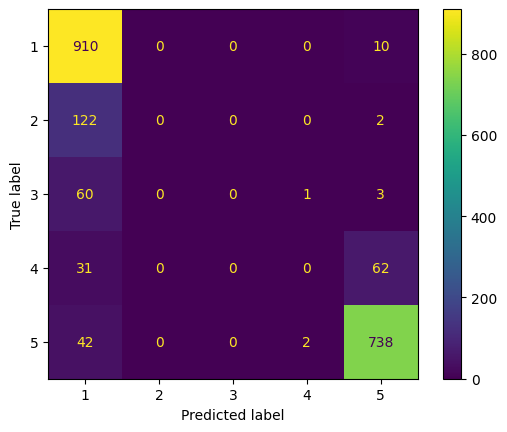

In [44]:
cm = confusion_matrix(labels_true, labels_pred, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_model.classes_)
disp.plot()
plt.show()

In [45]:
logreg_model_balanced = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=-1, 
                                 max_iter=2000, class_weight='balanced')

In [46]:
logreg_model_balanced.fit(train_data_features, train['rating_value'])

LogisticRegression(class_weight='balanced', max_iter=2000,
                   multi_class='multinomial', n_jobs=-1, random_state=17)

In [47]:
labels_pred_balanced = logreg_model_balanced.predict(valid_data_features)

In [48]:
print(f'accuracy: {accuracy_score(labels_true, labels_pred)}')

accuracy: 0.8310640443772063


In [49]:
precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred_balanced,average='micro')[:3]

print(f'MICRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

precision, recall, f1score = precision_recall_fscore_support(labels_true, labels_pred_balanced,average='macro')[:3]

print(f'MACRO AVERAGE: precision: {precision}, recall: {recall}, f1score: {f1score}')

MICRO AVERAGE: precision: 0.7423096318709027, recall: 0.7423096318709027, f1score: 0.7423096318709027
MACRO AVERAGE: precision: 0.45175718001804954, recall: 0.46538019415339765, f1score: 0.45596691598427236


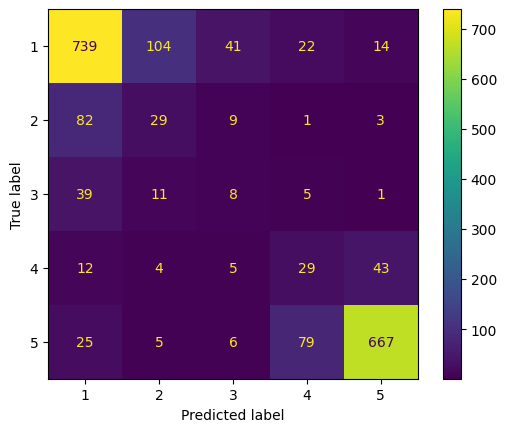

In [50]:
cm = confusion_matrix(labels_true, labels_pred_balanced, labels=logreg_model_balanced.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_model_balanced.classes_)
disp.plot()
plt.show()